In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az

In [ ]:
# URL of the CSV file
csv_url = "https://www.football-data.co.uk/new/BRA.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_url)

# Isolates the period under analysis
df = df[(df['Season'] >= 2019) & (df['Season'] <= 2024)]
df

,Country,League,Season,Date,Time,Home,Away,HG,AG,Res,...,PSCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,BFECH,BFECD,BFECA
2660,Brazil,Serie A,2019,27/04/2019,20:00,Sao Paulo,Botafogo RJ,2.0,0.0,H,...,5.61,1.81,3.60,5.80,1.74,3.37,5.14,NaN,NaN,NaN
2661,Brazil,Serie A,2019,27/04/2019,23:00,Atletico-MG,Avai,2.0,1.0,H,...,6.46,1.58,4.09,7.00,1.53,3.90,6.34,NaN,NaN,NaN
2662,Brazil,Serie A,2019,27/04/2019,23:00,Chapecoense-SC,Internacional,2.0,0.0,H,...,2.71,3.15,3.20,2.71,2.94,2.94,2.59,NaN,NaN,NaN
2663,Brazil,Serie A,2019,28/04/2019,01:00,Flamengo RJ,Cruzeiro,3.0,1.0,H,...,3.47,2.32,3.40,3.57,2.21,3.12,3.40,NaN,NaN,NaN
2664,Brazil,Serie A,2019,28/04/2019,15:00,Gremio,Santos,1.0,2.0,A,...,5.78,1.83,3.60,5.94,1.71,3.41,5.31,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,Brazil,Serie A,2024,08/12/2024,19:00,Flamengo RJ,Vitoria,2.0,2.0,D,...,7.93,1.40,5.30,8.25,1.37,5.02,7.66,1.41,5.40,9.00
4936,Brazil,Serie A,2024,08/12/2024,19:00,Fortaleza,Internacional,3.0,0.0,H,...,2.88,2.65,3.25,2.90,2.59,3.18,2.80,2.70,3.35,2.96
4937,Brazil,Serie A,2024,08/12/2024,19:00,Gremio,Corinthians,0.0,3.0,A,...,2.66,2.77,3.46,2.74,2.67,3.34,2.61,2.86,3.55,2.70
4938,Brazil,Serie A,2024,08/12/2024,19:00,Juventude,Cruzeiro,0.0,1.0,A,...,3.59,2.21,3.47,3.59,2.13,3.37,3.44,2.20,3.55,3.75


# Base simulation

In [ ]:
def simulate_bets(df):
    # Captures list of teams and years
    teams = df['Home'].unique()
    years = df['Season'].unique()

    # Creates dictionary to keep track of stats
    team_year_dict = {}
    for team in teams:
        team_year_dict[team] = {
            year: {"Total Bets": 0, "Correct Bets": 0, "AROB": 0.0, "Balance": 38, "Total Profit": 0.0} for year in years
        }

    # Isolates teams playing in each season
    for year in years:
        df_season = df[df['Season'] == year]
        season_teams = df_season['Home'].unique()

        # Isolates matches played by each team
        for team in season_teams:
            df_trimmed = df_season[(df_season['Home'] == team) | (df_season['Away'] == team)]

            # Temporary variables to track returns and profits for the season
            cummulative_return_on_bets = 0.0

            # Determines, in each match of a given team, if it played at home or away (and the odds associated with it)
            for index, row in df_trimmed.iterrows():
                if row['Home'] == team:
                    placement = "H"
                    odds = row['AvgCH']
                elif row['Away'] == team:
                    placement = "A"
                    odds = row['AvgCA']
                else:
                    continue

                # Updates stats
                team_year_dict[team][year]["Total Bets"] += 1
                if row['Res'] == placement:
                    team_year_dict[team][year]["Correct Bets"] += 1
                    team_year_dict[team][year]["Balance"] += odds - 1
                    cummulative_return_on_bets += odds

                else:
                    team_year_dict[team][year]["Balance"] -= 1
                    cummulative_return_on_bets -= 1


            # Calculate AROB and Total Profit as a percentage of $38
            total_bets = team_year_dict[team][year]["Total Bets"]
            team_year_dict[team][year]["AROB"] = cummulative_return_on_bets / total_bets if total_bets > 0 else 0.0
            team_year_dict[team][year]["Total Profit"] = ((team_year_dict[team][year]["Balance"] / 38) - 1) * 100

    return team_year_dict

In [ ]:
team_year_dict = simulate_bets(df)

# General analysis

In [ ]:
def fit_pymc(samples, success):
  '''
  Creates a PyMC model to estimate the sharpness parameter of a strategy
  over a given period of time
  '''
  with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1) # Prior
    x = pm.Binomial('x', n=samples, p=p, observed=success) # Likelihood

  with model:
    inference = pm.sample(progressbar=False)

  # Stores key variables
  mean = az.summary(inference, hdi_prob = 0.95)['mean'].values[0]
  lower = az.summary(inference, hdi_prob = 0.95)['hdi_2.5%'].values[0]
  upper = az.summary(inference, hdi_prob = 0.95)['hdi_97.5%'].values[0]

  print(f'  PyMC results for p: {mean} ({lower}, {upper})\n')

def summarize_annual_stats(team_year_dict):
    annual_summary = {}

    for year in next(iter(team_year_dict.values())).keys():
        total_bets = 0
        correct_bets = 0
        total_arob = 0.0
        total_profit = 0.0
        teams_in_season = 0

        for team, stats in team_year_dict.items():
            if stats[year]["Total Bets"] > 0:
                teams_in_season += 1
                total_bets += stats[year]["Total Bets"]
                correct_bets += stats[year].get("Correct Bets", 0)
                total_arob += stats[year]["AROB"]
                total_profit += stats[year]["Total Profit"]


        annual_summary[year] = {
            "Teams in Season": teams_in_season,
            "Total Bets": total_bets,
            "Correct Bets": correct_bets,
            "Average AROB": round(total_arob / teams_in_season, 2) if teams_in_season > 0 else 0.0,
            "Average Profit": round(total_profit / teams_in_season, 2) if teams_in_season > 0 else 0.0
        }

    return annual_summary

def print_annual_stats_and_totals(annual_summary):
    total_bets_overall = 0
    total_correct_bets_overall = 0
    total_arob_overall = 0.0
    total_profit_overall = 0.0
    total_years = len(annual_summary)

    print("Annual Summary:\n")
    for year, stats in annual_summary.items():
        print(f"Year: {year}")
        print(f"  Teams in Season: {stats['Teams in Season']}")
        print(f"  Total Bets: {stats['Total Bets']}")
        print(f"  Correct Bets: {stats['Correct Bets']}")
        print(f"  Average AROB: {stats['Average AROB']:.2f}")
        print(f"  Average Profit: {stats['Average Profit']:.2f}%\n")
        fit_pymc(stats['Total Bets'], stats['Correct Bets'])

        total_bets_overall += stats['Total Bets']
        total_correct_bets_overall += stats['Correct Bets']
        total_arob_overall += stats['Average AROB']
        total_profit_overall += stats['Average Profit']

    print("Totals for the Entire Period:\n")
    print(f"  Total Bets Placed: {total_bets_overall}")
    print(f"  Total Correct Bets: {total_correct_bets_overall}")
    print(f"  Average AROB: {total_arob_overall / total_years:.2f}")
    print(f"  Average Profit: {total_profit_overall / total_years:.2f}%")
    fit_pymc(total_bets_overall, total_correct_bets_overall)

In [ ]:
annual_summary = summarize_annual_stats(team_year_dict)
print_annual_stats_and_totals(annual_summary)

Annual Summary:

Year: 2019
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 282
  Average AROB: 0.29
  Average Profit: -8.52%

  PyMC results for p: 0.372 (0.339, 0.406)

Year: 2020
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 272
  Average AROB: 0.29
  Average Profit: -7.03%

  PyMC results for p: 0.359 (0.325, 0.391)

Year: 2021
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 267
  Average AROB: 0.25
  Average Profit: -10.15%

  PyMC results for p: 0.352 (0.318, 0.384)

Year: 2022
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 272
  Average AROB: 0.31
  Average Profit: -4.93%

  PyMC results for p: 0.358 (0.323, 0.39)

Year: 2023
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 282
  Average AROB: 0.35
  Average Profit: -2.43%

  PyMC results for p: 0.372 (0.337, 0.408)

Year: 2024
  Teams in Season: 20
  Total Bets: 760
  Correct Bets: 279
  Average AROB: 0.27
  Average Profit: -9.26%

  PyMC results for p: 0.368 (0.336, 0.403)

Totals for 

# Deep dive

## Profit distribution

In [ ]:
def create_profit_histogram(team_year_dict):

    # Step 1: Gather all profit values from the dictionary, excluding zeros
    all_profits = [year_stats["Total Profit"] for team_stats in team_year_dict.values() for year_stats in team_stats.values() if year_stats["Total Profit"] != 0]

    # Step 2: Calculate the mean, median, and standard deviation of the profits
    mean_profit = np.mean(all_profits)
    median_profit = np.median(all_profits)
    std_profit = np.std(all_profits)
    print(f"Standard Deviation of Profits: {std_profit:.2f}%")

    # Step 3: Create a Seaborn histogram for the profit percentages
    plt.figure(figsize=(10, 6))
    sns.histplot(all_profits, bins=30, color='skyblue', kde=False)

    # Step 4: Add mean and median lines for the profits
    plt.axvline(mean_profit, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_profit:.2f}%')
    plt.axvline(median_profit, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_profit:.2f}%')

    # Step 5: Add labels, title, and legend
    plt.title("Histogram of Seasonal Profits of Betting on One's Favorite Team")
    plt.xlabel("Profit per Season (as % of total amount staked)")
    plt.ylabel("Frequency")
    plt.legend()

    # Show the plot
    plt.show()

Standard Deviation of Profits: 25.07%


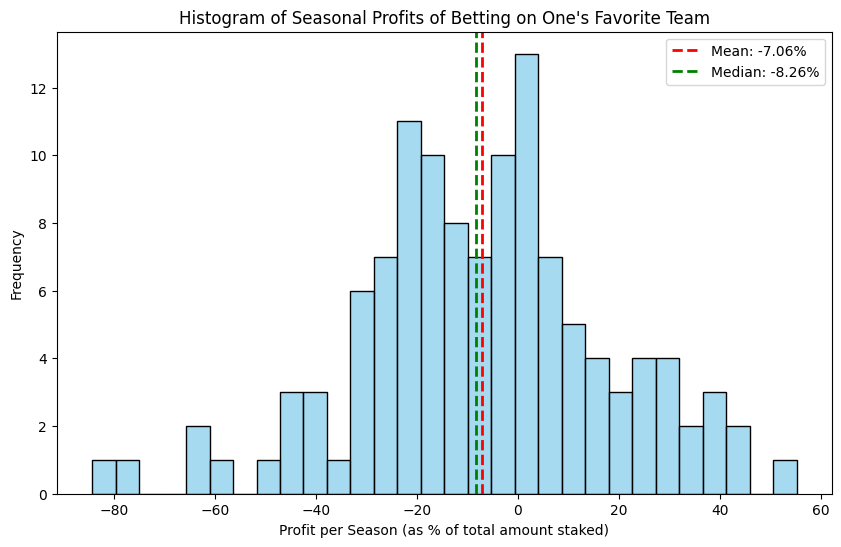

In [ ]:
create_profit_histogram(team_year_dict)

In [ ]:
def create_heatmap(team_year_dict):

    # Step 1: Prepare data for the heatmap
    team_year_dict_percentage = {}
    for team, year_dict in team_year_dict.items():
        team_year_dict_percentage[team] = {year: round(stats["Total Profit"], 0) for year, stats in year_dict.items()}

    # Convert the dictionary of dictionaries into a DataFrame
    df_heatmap = pd.DataFrame(team_year_dict_percentage)

    # Transpose the DataFrame so that teams are rows and years are columns
    df_heatmap = df_heatmap.T

    # Create a mask for values that are equal to 0
    mask = df_heatmap == 0

    # Define a custom annotation function to append "%" sign
    annot = df_heatmap.applymap(lambda x: f"{int(x)}%" if x != 0 else "")

    # Plot the heatmap using seaborn with a diverging colormap centered at 0
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_heatmap, annot=annot, cmap="RdYlGn", cbar=True, mask=mask, linewidths=0.5, linecolor='white',
                fmt="", vmin=-abs(df_heatmap.values).max(), vmax=abs(df_heatmap.values).max(), center=0,
                cbar_kws={'label': 'Profit (as % of total amount staked)'})

    # Set white for the zero cells
    plt.title("Profit of betting for a whole season on a specific team")
    plt.xlabel("Year")
    plt.ylabel("Team")
    plt.show()


<ipython-input-20-3e7341393728>:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = df_heatmap.applymap(lambda x: f"{int(x)}%" if x != 0 else "")


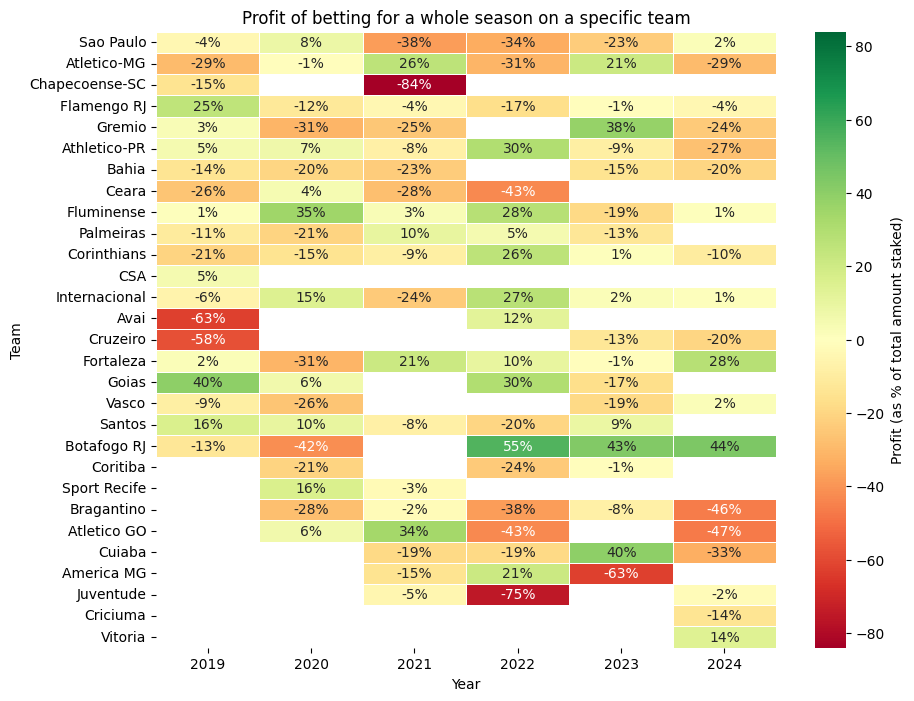

In [ ]:
create_heatmap(team_year_dict)

In [ ]:
def analyze_positive_profit_teams(team_year_dict):
    '''
    This answers the question: how many teams brought profit
    in more than half of the seasons they played?
    '''
    # Store results
    positive_profit_teams = []

    for team, years in team_year_dict.items():
        # Filter seasons where the team played (Total Bets > 0)
        played_seasons = [stats for stats in years.values() if stats["Total Bets"] > 0]
        if not played_seasons:
            continue

        # Count seasons with positive profit
        positive_seasons = sum(1 for stats in played_seasons if stats["Total Profit"] > 0)

        # Check if more than half of the seasons had positive profit
        if positive_seasons > len(played_seasons) / 2:
            # Calculate average profit for the team
            avg_profit = sum(stats["Total Profit"] for stats in played_seasons) / len(played_seasons)
            positive_profit_teams.append((team, avg_profit, len(played_seasons)))

    # Calculate overall stats
    total_teams = len(positive_profit_teams)
    overall_avg_profit = sum(team[1] for team in positive_profit_teams) / total_teams if total_teams > 0 else 0.0

    # Report results
    print(f"Total number of teams with positive profit in more than half of their seasons: {total_teams}")
    print(f"Overall average profit of these teams: {overall_avg_profit:.2f}%")
    print("\nTeams and their average profit:")
    for team, avg_profit, seasons_played in positive_profit_teams:
        print(f"Team: {team}, Average Profit: {avg_profit:.2f}%, Seasons Played: {seasons_played}")

    return positive_profit_teams

In [ ]:
_ = analyze_positive_profit_teams(team_year_dict)

Total number of teams with positive profit in more than half of their seasons: 8
Overall average profit of these teams: 8.53%

Teams and their average profit:
Team: Fluminense, Average Profit: 8.11%, Seasons Played: 6
Team: CSA, Average Profit: 5.18%, Seasons Played: 1
Team: Internacional, Average Profit: 2.62%, Seasons Played: 6
Team: Fortaleza, Average Profit: 4.86%, Seasons Played: 6
Team: Goias, Average Profit: 14.95%, Seasons Played: 4
Team: Santos, Average Profit: 1.29%, Seasons Played: 5
Team: Botafogo RJ, Average Profit: 17.35%, Seasons Played: 5
Team: Vitoria, Average Profit: 13.89%, Seasons Played: 1


In [ ]:
# Avg profit of the teams that played in more than half of the six seasons
np.mean([8.11, 2.62, 4.86, 14.95, 1.29, 17.35])

8.196666666666667

In [ ]:
def analyze_teams_with_min_seasons(team_year_dict, min_seasons=5):
    '''
    This answers the question: out of the teams who played in many seasons,
    what was their average profit?
    '''
    qualifying_teams = []
    total_combined_profit = 0.0
    total_seasons = 0

    for team, years in team_year_dict.items():
        # Filter seasons where the team played (Total Bets > 0)
        played_seasons = [stats for stats in years.values() if stats["Total Bets"] > 0]

        # Check if the team played in at least the minimum required seasons
        if len(played_seasons) >= min_seasons:
            # Calculate average profit for the team
            avg_profit = sum(stats["Total Profit"] for stats in played_seasons) / len(played_seasons)
            qualifying_teams.append((team, avg_profit, len(played_seasons)))

            # Update combined stats
            total_combined_profit += sum(stats["Total Profit"] for stats in played_seasons)
            total_seasons += len(played_seasons)

    # Calculate overall average profit per season
    overall_avg_profit = total_combined_profit / total_seasons if total_seasons > 0 else 0.0

    # Report results
    print(f"Number of teams that played in at least {min_seasons} seasons: {len(qualifying_teams)}")
    print(f"Average profit per season for these teams combined: {overall_avg_profit:.2f}%")
    print("\nTeams and their stats:")
    for team, avg_profit, seasons_played in qualifying_teams:
        print(f"Team: {team}, Average Profit per Season: {avg_profit:.2f}%, Seasons Played: {seasons_played}")

    # Create a DataFrame for seaborn
    teams_df = pd.DataFrame(qualifying_teams, columns=["Team", "Average Profit", "Seasons Played"])

    # Define the color based on profit (positive = green, negative = red)
    teams_df['Color'] = teams_df['Average Profit'].apply(lambda x: 'green' if x >= 0 else 'red')

    # Sort the DataFrame by absolute profit, with positive results first
    teams_df['Absolute Profit'] = teams_df['Average Profit'].abs()
    teams_df = teams_df.sort_values(by=['Average Profit', 'Absolute Profit'], ascending=[False, False])

    # Create the horizontal bar chart
    plt.figure(figsize=(10, len(qualifying_teams) * 0.5))
    sns.barplot(x="Average Profit", y="Team", data=teams_df, palette=teams_df['Color'].tolist())

    plt.title(f"Average Profit per Season for Famous Teams (Min {min_seasons} Seasons Played)")
    plt.xlabel("Average Profit (%)")
    plt.ylabel("Team")
    plt.show()


Number of teams that played in at least 5 seasons: 14
Average profit per season for these teams combined: -3.44%

Teams and their stats:
Team: Sao Paulo, Average Profit per Season: -14.90%, Seasons Played: 6
Team: Atletico-MG, Average Profit per Season: -7.03%, Seasons Played: 6
Team: Flamengo RJ, Average Profit per Season: -2.08%, Seasons Played: 6
Team: Gremio, Average Profit per Season: -7.77%, Seasons Played: 5
Team: Athletico-PR, Average Profit per Season: -0.44%, Seasons Played: 6
Team: Bahia, Average Profit per Season: -18.37%, Seasons Played: 5
Team: Fluminense, Average Profit per Season: 8.11%, Seasons Played: 6
Team: Palmeiras, Average Profit per Season: -5.00%, Seasons Played: 6
Team: Corinthians, Average Profit per Season: -4.71%, Seasons Played: 6
Team: Internacional, Average Profit per Season: 2.62%, Seasons Played: 6
Team: Fortaleza, Average Profit per Season: 4.86%, Seasons Played: 6
Team: Santos, Average Profit per Season: 1.29%, Seasons Played: 5
Team: Botafogo RJ, Av

<ipython-input-38-d75e8a993650>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Average Profit", y="Team", data=teams_df, palette=teams_df['Color'].tolist())


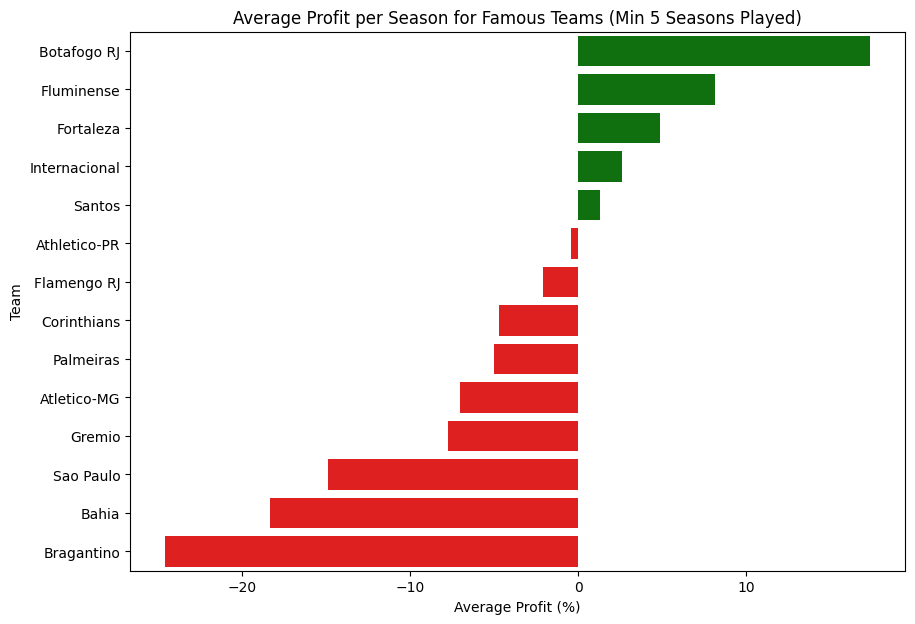

In [ ]:
analyze_teams_with_min_seasons(team_year_dict, min_seasons=5)

In [ ]:
def analyze_profit_distribution(team_year_dict):
    positive_profits = []
    negative_profits = []
    positive_count = 0
    negative_count = 0

    # Iterate through the dictionary and collect positive and negative profits
    for team, years in team_year_dict.items():
        for year, stats in years.items():
            profit = stats["Total Profit"]

            if profit > 0:
                positive_profits.append(profit)
                positive_count += 1
            elif profit < 0:
                negative_profits.append(profit)
                negative_count += 1

    # Calculate the average for positive profits if there are any
    avg_positive_profit = sum(positive_profits) / positive_count

    # Calculate the average for negative profits if there are any
    avg_negative_profit = sum(negative_profits) / negative_count

    # Print results
    print(f"Number of positive profit entries: {positive_count}")
    print(f"Number of negative profit entries: {negative_count}")
    print(f"Average positive profit: {avg_positive_profit:.2f}%")
    print(f"Average negative profit: {avg_negative_profit:.2f}%")

In [ ]:
analyze_profit_distribution(team_year_dict)

Number of positive profit entries: 46
Number of negative profit entries: 74
Average positive profit: 17.16%
Average negative profit: -22.10%
